<a href="https://colab.research.google.com/github/sheikhyounus123/pnemounoconosis-_detection/blob/main/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set the paths to your folders containing both X-ray and CT scan images
data_root_folder = '/content/drive/MyDrive/data and models/data'


Mounted at /content/drive


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to the dataset directory containing 'infected' and 'non_infected'
data_root_folder = '/content/drive/MyDrive/data and models/data'

# Create ImageDataGenerator for augmentation and rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)  # 80% train, 20% validation

# Use datagen to load data with train-test split
train_generator = datagen.flow_from_directory(
    data_root_folder,
    target_size=(224, 224),  # Input size of images for ResNet50
    batch_size=32,
    class_mode='binary',
    subset='training'  # Use 80% of the data for training
)

validation_generator = datagen.flow_from_directory(
   data_root_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Use 20% of the data for validation
)


Found 1233 images belonging to 2 classes.
Found 308 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Define the input layer with the correct input shape (e.g., (224, 224, 3) for RGB images)
input_tensor = Input(shape=(224, 224, 3))  # Adjust the input shape based on your data

# Load ResNet50 without the top classification layer (include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Add new layers on top of the ResNet50 base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Use global average pooling to flatten the output
x = Dense(1024, activation='relu')(x)  # Add a dense layer
predictions = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50 so that only the new layers on top are trained
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with an optimizer, loss function, and metrics
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Save the model (use .h5 extension for simplicity)
model.save('/content/drive/MyDrive/best_resnet50_model.h5')


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_resnet50_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Number of epochs can be adjusted
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 545s 12s/step - accuracy: 0.5129 - loss: 0.8985 - val_accuracy: 0.6104 - val_loss: 0.6870
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 339s 9s/step - accuracy: 0.5831 - loss: 0.7578 - val_accuracy: 0.6136 - val_loss: 0.5740
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 394s 9s/step - accuracy: 0.6524 - loss: 0.6505 - val_accuracy: 0.6721 - val_loss: 0.5080
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 379s 9s/step - accuracy: 0.6901 - loss: 0.5956 - val_accuracy: 0.7143 - val_loss: 0.4747
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 369s 8s/step - accuracy: 0.7306 - loss: 0.5405 - val_accuracy: 0.7857 - val_loss: 0.4085
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 377s 8s/step - accuracy: 0.7609 - loss: 0.5012 - val_accuracy: 0.8799 - val_loss: 0.3387
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 356s 9s/step - accuracy: 0.8061 - loss: 0.4575 - val_accuracy: 0.8636 - val_loss: 0.3135
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 355s 8s/step - accuracy: 0.8127 - loss: 0.4131 - val_accuracy: 0.8734 - val_loss: 0

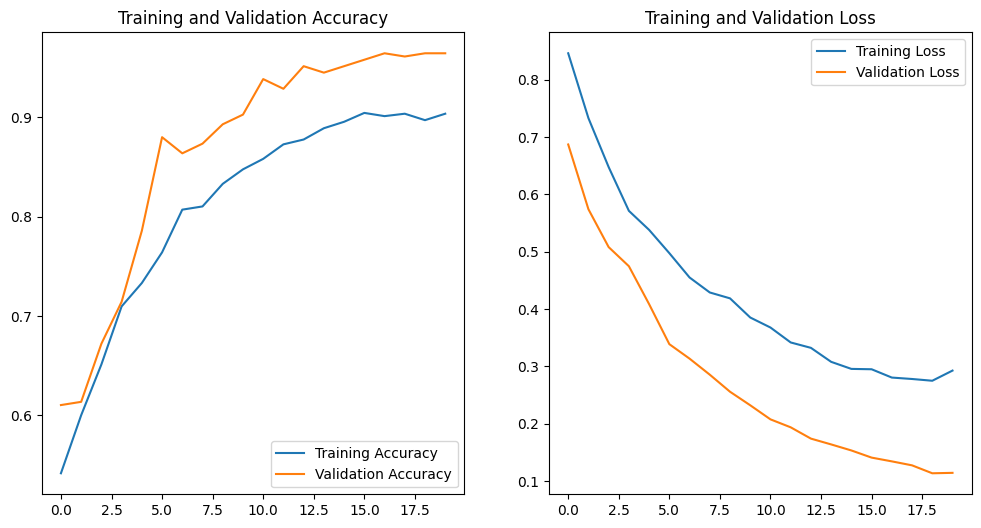

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
# Load the model
best_model = load_model('/content/drive/MyDrive/best_resnet50_model.h5')

# Recompile the model to ensure it has the correct optimizer, loss, and metrics
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for the test set (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Assuming your test dataset is in '/path_to_test_data', with 'infected' and 'non_infected' folders inside
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/data and models/data',
    target_size=(224, 224),  # Resize all images to the same size as your training images
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 1541 images belonging to 2 classes.


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 319s 6s/step - accuracy: 0.8965 - loss: 0.5690
Test accuracy: 0.6099935173988342


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved ResNet50 model
best_model = load_model('/content/drive/MyDrive/best_resnet50_model.h5')

# Compile the model after loading to ensure metrics are set
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the model on the validation data
validation_loss, validation_acc = best_model.evaluate(validation_generator)
print(f"Validation accuracy: {validation_acc}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.6014 - loss: 0.6756
Validation accuracy: 0.6103895902633667


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation data
y_true = validation_generator.classes  # True labels
y_pred = best_model.predict(validation_generator)  # Predictions
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels from predictions

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)


10/10 ━━━━━━━━━━━━━━━━━━━━ 72s 6s/step


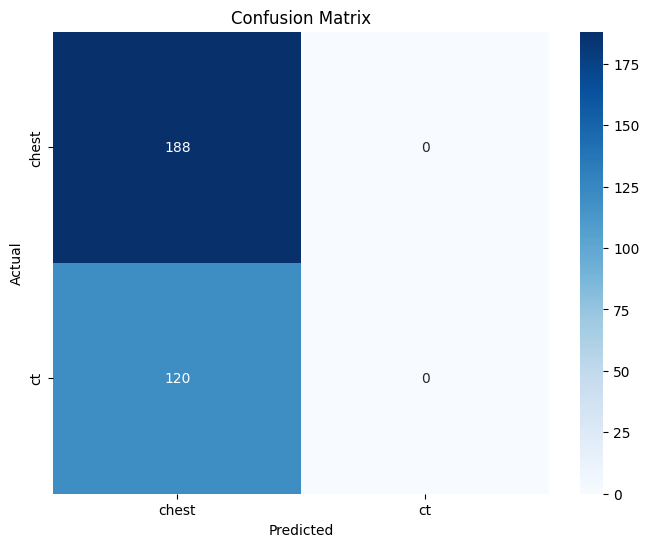

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


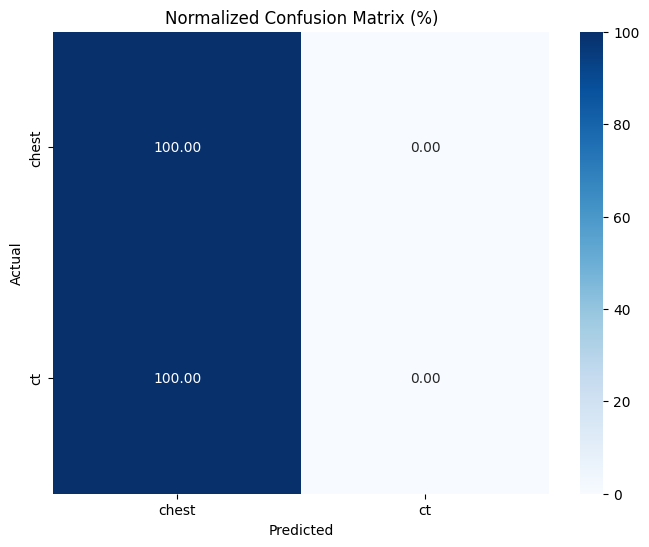

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred_classes are already defined as per previous instructions
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Normalize the confusion matrix by row (i.e., by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Convert counts to percentages

# Optionally, multiply by 100 to convert to percentage values
cm_normalized *= 100

# Plotting the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix (%)')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    # Load an image from the specified path
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Scale pixel values
    return img_array

def predict_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    prediction = best_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    return predicted_class

# Example usage
image_paths = [
    '/content/drive/MyDrive/data and models/data/chest/Chest_infected/yxppt-2020-02-19_00-51-27_287214-day10.jpg',
    '/content/drive/MyDrive/data and models/data/ct/CT_infected/Talaromyces-marneffei-infection-relapse-presenting-as-ost_2020_International-p1-12_1.png',
    # Add more image paths as needed
]

for img_path in image_paths:
    pred = predict_image(img_path)
    # Convert dict_keys to a list so it can be indexed
    class_labels = list(validation_generator.class_indices.keys())
    class_label = class_labels[pred[0]]
    print(f"Predicted class for {img_path}: {class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Predicted class for /content/drive/MyDrive/data and models/data/chest/Chest_infected/yxppt-2020-02-19_00-51-27_287214-day10.jpg: chest
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Predicted class for /content/drive/MyDrive/data and models/data/ct/CT_infected/Talaromyces-marneffei-infection-relapse-presenting-as-ost_2020_International-p1-12_1.png: chest


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    # Load an image from the specified path
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Scale pixel values
    return img_array

def predict_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    prediction = best_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)  # Get the index of the class with the highest probability
    return predicted_class

# Example usage
image_paths = [
    '/content/drive/MyDrive/data and models/data/chest/Chest_infected/yxppt-2020-02-19_00-51-27_287214-day10.jpg',
    '/content/drive/MyDrive/data and models/data/ct/CT_infected/Talaromyces-marneffei-infection-relapse-presenting-as-ost_2020_International-p1-12_1.png',
    # Add more image paths as needed
]

# Convert dict_keys to a list so it can be indexed
class_labels = list(validation_generator.class_indices.keys())

for img_path in image_paths:
    pred = predict_image(img_path)
    class_label = class_labels[pred[0]]  # Get the corresponding class label
    print(f"Predicted class for {img_path}: {class_label}")

# Check the output class labels
print("Class Indices:", validation_generator.class_indices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Predicted class for /content/drive/MyDrive/data and models/data/chest/Chest_infected/yxppt-2020-02-19_00-51-27_287214-day10.jpg: chest
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
Predicted class for /content/drive/MyDrive/data and models/data/ct/CT_infected/Talaromyces-marneffei-infection-relapse-presenting-as-ost_2020_International-p1-12_1.png: chest
Class Indices: {'chest': 0, 'ct': 1}
